DISTILBERT SENTIMENT ANALYSE

In [ ]:
#!pip install --upgrade pip setuptools wheel
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
#!pip install transformers pandas matplotlib

In [2]:
#Load resources
import pandas as pd
from transformers import pipeline

In [3]:
#load data
data= pd.read_csv('Comb_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67992 entries, 0 to 67991
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              67992 non-null  object 
 1   name            61232 non-null  object 
 2   brand           67992 non-null  object 
 3   reviews.date    67953 non-null  object 
 4   reviews.rating  67959 non-null  float64
 5   reviews.text    67991 non-null  object 
 6   reviews.title   67973 non-null  object 
dtypes: float64(1), object(6)
memory usage: 3.6+ MB


In [ ]:
## Model selection

sentiment_pipe = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

In [6]:
texts = data["reviews.text"].fillna("").astype(str).tolist()


In [9]:
# start small first (fast)
results = sentiment_pipe(texts[:200], batch_size=32, truncation=True)

data.loc[:200, "bert_sentiment"] = [r["label"] for r in results]
data.loc[:200, "bert_score"] = [r["score"] for r in results]

data[["reviews.text", "bert_sentiment", "bert_score"]].head(10)

ValueError: Must have equal len keys and value when setting with an iterable

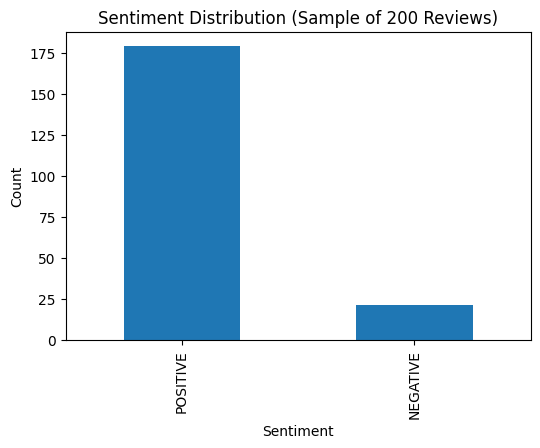

In [8]:
# Plot the sentiment distribution (for the sample)
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
data["bert_sentiment"][:200].value_counts().plot(kind="bar")
plt.title("Sentiment Distribution (Sample of 200 Reviews)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [11]:
## Create sentiment labels from ratings:

def rating_to_sentiment(rating):
    if rating >= 4:
        return 1   # positive
    elif rating == 3:
        return 0   # neutral (optional)
    else:
        return -1  # negative

data["sentiment"] = data["reviews.rating"].apply(rating_to_sentiment)

In [12]:
## Keeping only needed columnn:

df = data[["reviews.text", "sentiment"]].dropna()
df = df.rename(columns={"reviews.text": "text"})

In [13]:
## Splitting data into train and test sets:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["sentiment"]) #keeping class balance

#Check sizes:
print(f"Train set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")


Train set size: 54392
Test set size: 13599


In [14]:
## Converting to Hugging Face Datasets format:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

In [15]:
## SAnity check:
print(train_dataset[0])

{'text': "Great deal- don't waste any more money buying batteries at the store! You can't beat the price and they work and lask as well as brand name batterys. It it amazing how much cheaper these are- and you get twice as many. I got these in AA, AAA, C and D. The main reason I even bought them was when I was looking for flashlight batteries- size D for my trusty maglight (yes they are heavy but I love them for it, they are perfect for a car and the weight keeps it steady if you have to put it down) and size C for a different flashlight. Of course I needed an odd number and couldn't believe how expensive they were in the store. I checked Amazon- had no clue amazon had their own batteries and noticed that in all of the sizes- the price was less then the smallest pack of that size in the store and had twice as many batteries. Did I need this many AAA batteries at the time- nope but let me tell you I'm so glad I got extra- less than a week after buying them I had already nearly used ever

In [16]:
## Tokenizing the data with DistilBERT tokenizer:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(df):
    return tokenizer(df["text"],
        padding="max_length",
        truncation=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Usuario\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]